<a href="https://colab.research.google.com/github/abinabrahamjohn/NLP_Mini_Projects/blob/master/Recommendation_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
input_path='/content/drive/My Drive/NLP Colab Notebooks/Data/Online_Retail.xlsx'
df = pd.read_excel(input_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Remove missing values

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# remove missing values
df.dropna(inplace=True)

### Data Preparation

In [10]:
df['StockCode']= df['StockCode'].astype(str)

In [11]:
# Unique customers
customers = df["CustomerID"].unique().tolist()

In [12]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

### List to capture purchase history

In [13]:
# list to capture purchase history of the customers - training
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:06<00:00, 628.19it/s]


In [14]:
# list to capture purchase history of the customers - validation
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1147.60it/s]


### Build Word2Vec

In [15]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3650920, 3688200)

In [16]:
model.init_sims(replace=True)


In [17]:
print(model)


Word2Vec(vocab=3169, size=100, alpha=0.03)


In [18]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3169, 100)

In [19]:
X

array([[-0.08828843, -0.01248132,  0.01400501, ...,  0.090625  ,
        -0.10381665, -0.04912074],
       [-0.10833003, -0.11381141,  0.00334974, ...,  0.03244193,
        -0.1105096 , -0.08995666],
       [-0.15277913, -0.05382976, -0.0362289 , ...,  0.08603001,
        -0.002143  , -0.05108384],
       ...,
       [-0.02604857,  0.11316232, -0.29362327, ...,  0.15758958,
         0.13889009,  0.15416087],
       [-0.08760762,  0.10234199,  0.15327576, ...,  0.03623384,
        -0.09421591,  0.08520585],
       [ 0.06080618,  0.26666617, -0.03914763, ...,  0.06543396,
        -0.09987226, -0.01522621]], dtype=float32)

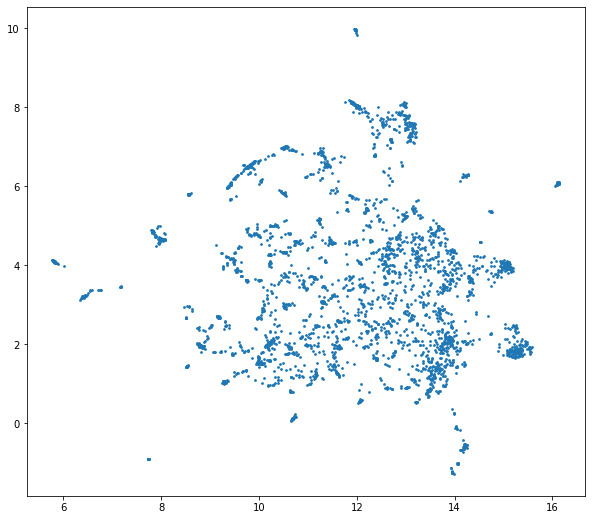

In [20]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

### Recommending Products

In [21]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [22]:
#Find top 6 simlar products based on 1 product
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [24]:
similar_products(model['71053'])


[('LANTERN CREAM GAZEBO ', 0.6315523386001587),
 ('GLASS STAR FROSTED T-LIGHT HOLDER', 0.6301409602165222),
 ('COLOURED GLASS STAR T-LIGHT HOLDER', 0.6011258363723755),
 ('FRENCH CARRIAGE LANTERN', 0.5812472105026245),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.5571494102478027),
 ('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.556302011013031)]

In [25]:
#Find mean of the vectors based on user's purchase history
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [29]:
similar_products(aggregate_vectors(purchases_val[0]))

[('MINI PAINT SET VINTAGE ', 0.7203538417816162),
 ('SPACEBOY LUNCH BOX ', 0.7028573751449585),
 ('PLASTERS IN TIN CIRCUS PARADE ', 0.69647216796875),
 ('PLASTERS IN TIN SPACEBOY', 0.6883918046951294),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6847771406173706),
 ('SET/6 RED SPOTTY PAPER CUPS', 0.6819559335708618)]

In [30]:
similar_products(aggregate_vectors(purchases_val[0][-5:]))

[('ALARM CLOCK BAKELIKE PINK', 0.7647929787635803),
 ('ALARM CLOCK BAKELIKE GREEN', 0.7312866449356079),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.7311700582504272),
 ('STRAWBERRY LUNCH BOX WITH CUTLERY', 0.7056992650032043),
 ('ALARM CLOCK BAKELIKE RED ', 0.7010701894760132),
 ('SPACEBOY LUNCH BOX ', 0.6924804449081421)]